In [1]:
import pandas as pd
import numpy as np
import simpy
import random
import matplotlib.pyplot as plt


In [2]:
class Lavadora:
    """Lavadora disponible para los clientes"""
    def __init__(self, env, id):
        self.env = env
        self.id = id
        self.recurso = simpy.Resource(env, capacity=1)  # Solo una persona puede usar cada lavadora


In [3]:
class Secadora:
    """Secadora disponible para los clientes"""
    def __init__(self, env, id):
        self.env = env
        self.id = id
        self.recurso = simpy.Resource(env, capacity=1)  # Solo una persona puede usar cada secadora


In [4]:
class Lavanderia:
    """Establecimiento de lavandería automática"""
    def __init__(self, env, num_lavadoras, num_secadoras):
        self.env = env
        self.lavadoras = [Lavadora(env, i+1) for i in range(num_lavadoras)]
        self.secadoras = [Secadora(env, i+1) for i in range(num_secadoras)]


In [ ]:
class Cliente:
    """Cliente que llega a la lavandería"""
    def __init__(self, env, id, lavanderia, usa_secadora=True):
        self.env = env
        self.id = id
        self.lavanderia = lavanderia
        self.usa_secadora = usa_secadora  # Si va a usar la secadora después de lavar
        self.tiempo_lavado = random.randint(20, 30)  # Tiempo aleatorio de lavado entre 20-30 minutos
        self.tiempo_secado = random.randint(20, 30)  # Tiempo aleatorio de secado entre 20-30 minutos
        self.eventos = pd.DataFrame()
        self.completo_servicio = False
        self.env.process(self.proceso_lavanderia())

    def registrar_evento(self, evento):
        """Registrar un evento en el historial del cliente"""
        nuevo_evento = pd.DataFrame({
            "id_cliente": [self.id],
            "evento": [evento],
            "tiempo": [self.env.now]
        })
        self.eventos = pd.concat([self.eventos, nuevo_evento])
    
    def proceso_lavanderia(self):
        """Proceso completo del cliente en la lavandería"""
        # Llegada del cliente
        hora_llegada = self.env.now
        self.registrar_evento("LLEGADA")
        
        # Print estilizado para la llegada
        print(f"{int(self.env.now)}: El cliente {self.id} llegó a la lavandería")
        
        # Buscar una lavadora disponible
        lavadora_seleccionada = None
        for lavadora in self.lavanderia.lavadoras:
            if lavadora.recurso.count < lavadora.recurso.capacity:
                lavadora_seleccionada = lavadora
                break
        
        if not lavadora_seleccionada:
            # No hay lavadoras disponibles, se va
            self.registrar_evento("SE_VA_SIN_LAVADORA")
            print(f"{int(self.env.now)}: El cliente {self.id} se fue porque no hay lavadoras disponibles")
            return
        
        # Usar la lavadora
        with lavadora_seleccionada.recurso.request() as req:
            yield req
            self.registrar_evento(f"INICIA_LAVADO_LAVADORA_{lavadora_seleccionada.id}")
            print(f"{int(self.env.now)}: El cliente {self.id} inició lavado en la lavadora {lavadora_seleccionada.id} (tiempo: {self.tiempo_lavado} min)")
            
            # Tiempo de lavado aleatorio
            yield self.env.timeout(self.tiempo_lavado)
            
            self.registrar_evento(f"FINALIZA_LAVADO_LAVADORA_{lavadora_seleccionada.id}")
            print(f"{int(self.env.now)}: El cliente {self.id} terminó lavado en la lavadora {lavadora_seleccionada.id}")
        
        # Si quiere usar la secadora
        if self.usa_secadora:
            # Buscar una secadora disponible
            secadora_seleccionada = None
            for secadora in self.lavanderia.secadoras:
                if secadora.recurso.count < secadora.recurso.capacity:
                    secadora_seleccionada = secadora
                    break
            
            if not secadora_seleccionada:
                # No hay secadoras disponibles, se va con la ropa húmeda
                self.registrar_evento("SE_VA_SIN_SECADORA")
                print(f"{int(self.env.now)}: El cliente {self.id} se fue sin poder secar su ropa")
                self.completo_servicio = True  # Completó al menos el lavado
                return
            
            # Usar la secadora
            with secadora_seleccionada.recurso.request() as req:
                yield req
                self.registrar_evento(f"INICIA_SECADO_SECADORA_{secadora_seleccionada.id}")
                print(f"{int(self.env.now)}: El cliente {self.id} inició secado en la secadora {secadora_seleccionada.id} (tiempo: {self.tiempo_secado} min)")
                
                # Tiempo de secado aleatorio
                yield self.env.timeout(self.tiempo_secado)
                
                self.registrar_evento(f"FINALIZA_SECADO_SECADORA_{secadora_seleccionada.id}")
                print(f"{int(self.env.now)}: El cliente {self.id} terminó secado en la secadora {secadora_seleccionada.id}")
        
        # Cliente completó todo su proceso
        self.registrar_evento("SERVICIO_COMPLETO")
        print(f"{int(self.env.now)}: El cliente {self.id} completó todo su servicio")
        self.completo_servicio = True


In [6]:
class Simulacion:
    """Controlador de la simulación"""
    def __init__(self, env, num_lavadoras, num_secadoras, tasa_llegada_min=10, tasa_llegada_max=20):
        self.env = env
        self.lavanderia = Lavanderia(env, num_lavadoras, num_secadoras)
        self.clientes = []
        self.tasa_llegada_min = tasa_llegada_min
        self.tasa_llegada_max = tasa_llegada_max
        self.env.process(self.generador_clientes())
        # Para llevar estadísticas
        self.lavadoras_utilizadas = 0
        self.secadoras_utilizadas = 0
        self.clientes_sin_servicio = 0
    
    def generador_clientes(self):
        """Genera clientes con cierta frecuencia"""
        id_cliente = 1
        while True:
            # Esperar un tiempo aleatorio entre llegadas de clientes
            yield self.env.timeout(random.randint(self.tasa_llegada_min, self.tasa_llegada_max))
            
            # Crear un nuevo cliente con parámetros aleatorios
            cliente = Cliente(
                self.env,
                id_cliente,
                self.lavanderia,
                usa_secadora=random.choice([True, False])  # 50% usa secadora
            )
            
            self.clientes.append(cliente)
            id_cliente += 1


In [7]:
def ejecutar_simulacion(duracion):
    """
    Ejecuta la simulación de la lavandería
    
    Args:
        duracion: Duración de la simulación en minutos (default: 480 = 8 horas)
    
    Returns:
        Objeto de simulación con los resultados
    """
    random.seed(112)
    env = simpy.Environment()
    
    print("\n===== INICIANDO SIMULACIÓN DE LAVANDERÍA AUTOMÁTICA =====")
    print(f"Duración: {duracion} minutos ({duracion/60} horas)")
    print("Configuración: 5 lavadoras, 3 secadoras")
    print("=========================================================\n")
    
    # Configuración: 5 lavadoras, 3 secadoras
    sim = Simulacion(env, num_lavadoras=5, num_secadoras=3)
    
    # Ejecutar la simulación
    env.run(until=duracion)
    
    print("\n===== SIMULACIÓN FINALIZADA =====")
    print(f"Total de clientes: {len(sim.clientes)}")
    
    # Calcular estadísticas simples
    clientes_atendidos = sum(1 for cliente in sim.clientes if cliente.completo_servicio)
    clientes_sin_lavadora = sum(1 for cliente in sim.clientes 
                               if any("SE_VA_SIN_LAVADORA" in evento for evento in cliente.eventos["evento"].values))
    clientes_sin_secadora = sum(1 for cliente in sim.clientes 
                               if any("SE_VA_SIN_SECADORA" in evento for evento in cliente.eventos["evento"].values))
    
    print(f"Clientes que completaron servicio: {clientes_atendidos}")
    print(f"Clientes que se fueron sin lavadora: {clientes_sin_lavadora}")
    print(f"Clientes que se fueron sin secadora: {clientes_sin_secadora}")
    print("=================================\n")
    
    return sim


In [8]:
def analizar_resultados(simulacion):
    """
    Analiza los resultados de la simulación
    
    Args:
        simulacion: Objeto de simulación con los resultados
    
    Returns:
        DataFrame con eventos y DataFrame con información de clientes
    """
    # Recopilar eventos de todos los clientes
    eventos = []
    for cliente in simulacion.clientes:
        eventos.append(cliente.eventos)
    
    df_eventos = pd.concat(eventos)
    df_eventos = df_eventos.reset_index(drop=True)
    
    # Crear DataFrame con información de los clientes
    clientes_info = []
    for cliente in simulacion.clientes:
        clientes_info.append({
            "id_cliente": cliente.id,
            "tiempo_lavado": cliente.tiempo_lavado,
            "tiempo_secado": cliente.tiempo_secado,
            "usa_secadora": cliente.usa_secadora,
            "completo_servicio": cliente.completo_servicio
        })
    
    df_clientes = pd.DataFrame(clientes_info)
    
    return df_eventos, df_clientes


In [9]:
# Función para calcular tiempos de espera
def calcular_tiempos_espera(df_eventos):
    """
    Calcula los tiempos de espera entre eventos
    
    Args:
        df_eventos: DataFrame con los eventos
    
    Returns:
        DataFrame con tiempos de espera
    """
    # Crear una copia para no modificar el original
    df = df_eventos.copy()
    
    # Ordenar por cliente y tiempo
    df = df.sort_values(["id_cliente", "tiempo"])
    
    # Calcular tiempo entre eventos para cada cliente
    df["tiempo_anterior"] = df.groupby("id_cliente")["tiempo"].shift(1)
    df["tiempo_espera"] = df["tiempo"] - df["tiempo_anterior"]
    
    return df

In [10]:
def responder_preguntas(sim, df_eventos, df_clientes):
    """
    Responde a las preguntas clave de la simulación
    
    Args:
        sim: Objeto de simulación
        df_eventos: DataFrame con eventos
        df_clientes: DataFrame con información de clientes
    """
    # Calcular tiempos de espera
    df_con_espera = calcular_tiempos_espera(df_eventos)
    
    print("======= ANÁLISIS DE LA SIMULACIÓN DE LAVANDERÍA =======")
    
    # Pregunta 1: Tiempo promedio de espera para usar una lavadora
    espera_lavadora = df_con_espera[df_con_espera["evento"].str.contains("INICIA_LAVADO")].copy()
    tiempo_espera_lavadora = espera_lavadora["tiempo"] - espera_lavadora["id_cliente"].map(
        df_eventos[df_eventos["evento"] == "LLEGADA"].set_index("id_cliente")["tiempo"]
    )
    print(f"\n1. Tiempo promedio de espera para usar una lavadora: {tiempo_espera_lavadora.mean():.2f} minutos")
    
    # Pregunta 2: Porcentaje de clientes que completaron todo el servicio
    total_clientes = len(df_clientes)
    clientes_completos = df_clientes["completo_servicio"].sum()
    porcentaje_completos = (clientes_completos / total_clientes) * 100
    print(f"\n2. Porcentaje de clientes que completaron todo el servicio: {porcentaje_completos:.2f}%")
    
    # Pregunta 3: Tiempo promedio total en la lavandería
    tiempo_total = []
    for cliente_id in df_clientes["id_cliente"]:
        eventos_cliente = df_eventos[df_eventos["id_cliente"] == cliente_id]
        if len(eventos_cliente) >= 2:
            llegada = eventos_cliente[eventos_cliente["evento"] == "LLEGADA"]["tiempo"].iloc[0]
            ultimo_evento = eventos_cliente["tiempo"].max()
            tiempo_total.append(ultimo_evento - llegada)
    
    if tiempo_total:
        print(f"\n3. Tiempo promedio total en la lavandería: {np.mean(tiempo_total):.2f} minutos")
    
    # Pregunta 4: Utilización de lavadoras y secadoras
    eventos_lavado = df_eventos[df_eventos["evento"].str.contains("INICIA_LAVADO")]
    eventos_secado = df_eventos[df_eventos["evento"].str.contains("INICIA_SECADO")]
    
    lavadoras_usadas = {}
    for evento in eventos_lavado["evento"]:
        lavadora_id = int(evento.split("_")[-1])
        lavadoras_usadas[lavadora_id] = lavadoras_usadas.get(lavadora_id, 0) + 1
    
    secadoras_usadas = {}
    for evento in eventos_secado["evento"]:
        secadora_id = int(evento.split("_")[-1])
        secadoras_usadas[secadora_id] = secadoras_usadas.get(secadora_id, 0) + 1
    
    print("\n4. Utilización de cada recurso:")
    print("   Lavadoras:")
    for lavadora_id, usos in sorted(lavadoras_usadas.items()):
        print(f"   - Lavadora {lavadora_id}: {usos} usos")
    
    print("   Secadoras:")
    for secadora_id, usos in sorted(secadoras_usadas.items()):
        print(f"   - Secadora {secadora_id}: {usos} usos")
    
    # Pregunta 5: Porcentaje de clientes que se fueron sin servicio por tipo
    se_fueron_sin_lavadora = df_eventos[df_eventos["evento"] == "SE_VA_SIN_LAVADORA"].shape[0]
    se_fueron_sin_secadora = df_eventos[df_eventos["evento"] == "SE_VA_SIN_SECADORA"].shape[0]
    
    print("\n5. Clientes que se fueron sin completar el servicio:")
    print(f"   - Sin conseguir lavadora: {se_fueron_sin_lavadora} ({se_fueron_sin_lavadora/total_clientes*100:.2f}%)")
    print(f"   - Sin conseguir secadora: {se_fueron_sin_secadora} ({se_fueron_sin_secadora/total_clientes*100:.2f}%)")
    
    return {
        "tiempo_espera_lavadora": tiempo_espera_lavadora.mean(),
        "porcentaje_completos": porcentaje_completos,
        "tiempo_promedio_total": np.mean(tiempo_total) if tiempo_total else 0,
        "lavadoras_usadas": lavadoras_usadas,
        "secadoras_usadas": secadoras_usadas,
        "se_fueron_sin_lavadora": se_fueron_sin_lavadora,
        "se_fueron_sin_secadora": se_fueron_sin_secadora
    }


In [11]:
# Visualización de resultados
def visualizar_resultados(resultados, df_clientes):
    """
    Crea visualizaciones de los resultados
    
    Args:
        resultados: Diccionario con resultados del análisis
        df_clientes: DataFrame con información de clientes
    """
    # Crear figura con 2x2 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Gráfico 1: Servicios completados vs no completados
    labels = ['Completado', 'No completado']
    sizes = [resultados["porcentaje_completos"], 100 - resultados["porcentaje_completos"]]
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')
    ax1.set_title('Porcentaje de servicios completados')
    
    # Gráfico 2: Utilización de lavadoras
    lavadoras = list(resultados["lavadoras_usadas"].keys())
    usos_lavadoras = [resultados["lavadoras_usadas"][lav] for lav in lavadoras]
    ax2.bar([f"Lavadora {lav}" for lav in lavadoras], usos_lavadoras)
    ax2.set_title('Utilización de lavadoras')
    ax2.set_ylabel('Número de usos')
    
    # Gráfico 3: Distribución de tiempos de lavado y secado
    ax3.hist(df_clientes['tiempo_lavado'], bins=10, alpha=0.7, label='Lavado')
    ax3.hist(df_clientes['tiempo_secado'], bins=10, alpha=0.7, label='Secado')
    ax3.set_title('Distribución de tiempos de lavado y secado')
    ax3.set_xlabel('Tiempo (minutos)')
    ax3.set_ylabel('Frecuencia')
    ax3.legend()
    
    # Gráfico 4: Razones por las que los clientes se fueron
    razones = ['Sin lavadora', 'Sin secadora']
    cantidades = [
        resultados["se_fueron_sin_lavadora"],
        resultados["se_fueron_sin_secadora"]
    ]
    ax4.bar(razones, cantidades)
    ax4.set_title('Razones por las que los clientes se fueron')
    ax4.set_ylabel('Cantidad de clientes')
    
    plt.tight_layout()
    plt.show()


Ejecutando simulación de lavandería automática...

===== INICIANDO SIMULACIÓN DE LAVANDERÍA AUTOMÁTICA =====
Duración: 480 minutos (8.0 horas)
Configuración: 5 lavadoras, 3 secadoras

17: El cliente 1 llegó a la lavandería
17: El cliente 1 inició lavado en la lavadora 1 (tiempo: 27 min)
37: El cliente 2 llegó a la lavandería
37: El cliente 2 inició lavado en la lavadora 2 (tiempo: 25 min)
44: El cliente 1 terminó lavado en la lavadora 1
44: El cliente 1 completó todo su servicio
55: El cliente 3 llegó a la lavandería
55: El cliente 3 inició lavado en la lavadora 1 (tiempo: 20 min)
62: El cliente 2 terminó lavado en la lavadora 2
62: El cliente 2 inició secado en la secadora 1 (tiempo: 23 min)
74: El cliente 4 llegó a la lavandería
74: El cliente 4 inició lavado en la lavadora 2 (tiempo: 27 min)
75: El cliente 3 terminó lavado en la lavadora 1
75: El cliente 3 completó todo su servicio
85: El cliente 2 terminó secado en la secadora 1
85: El cliente 2 completó todo su servicio
88: El cli

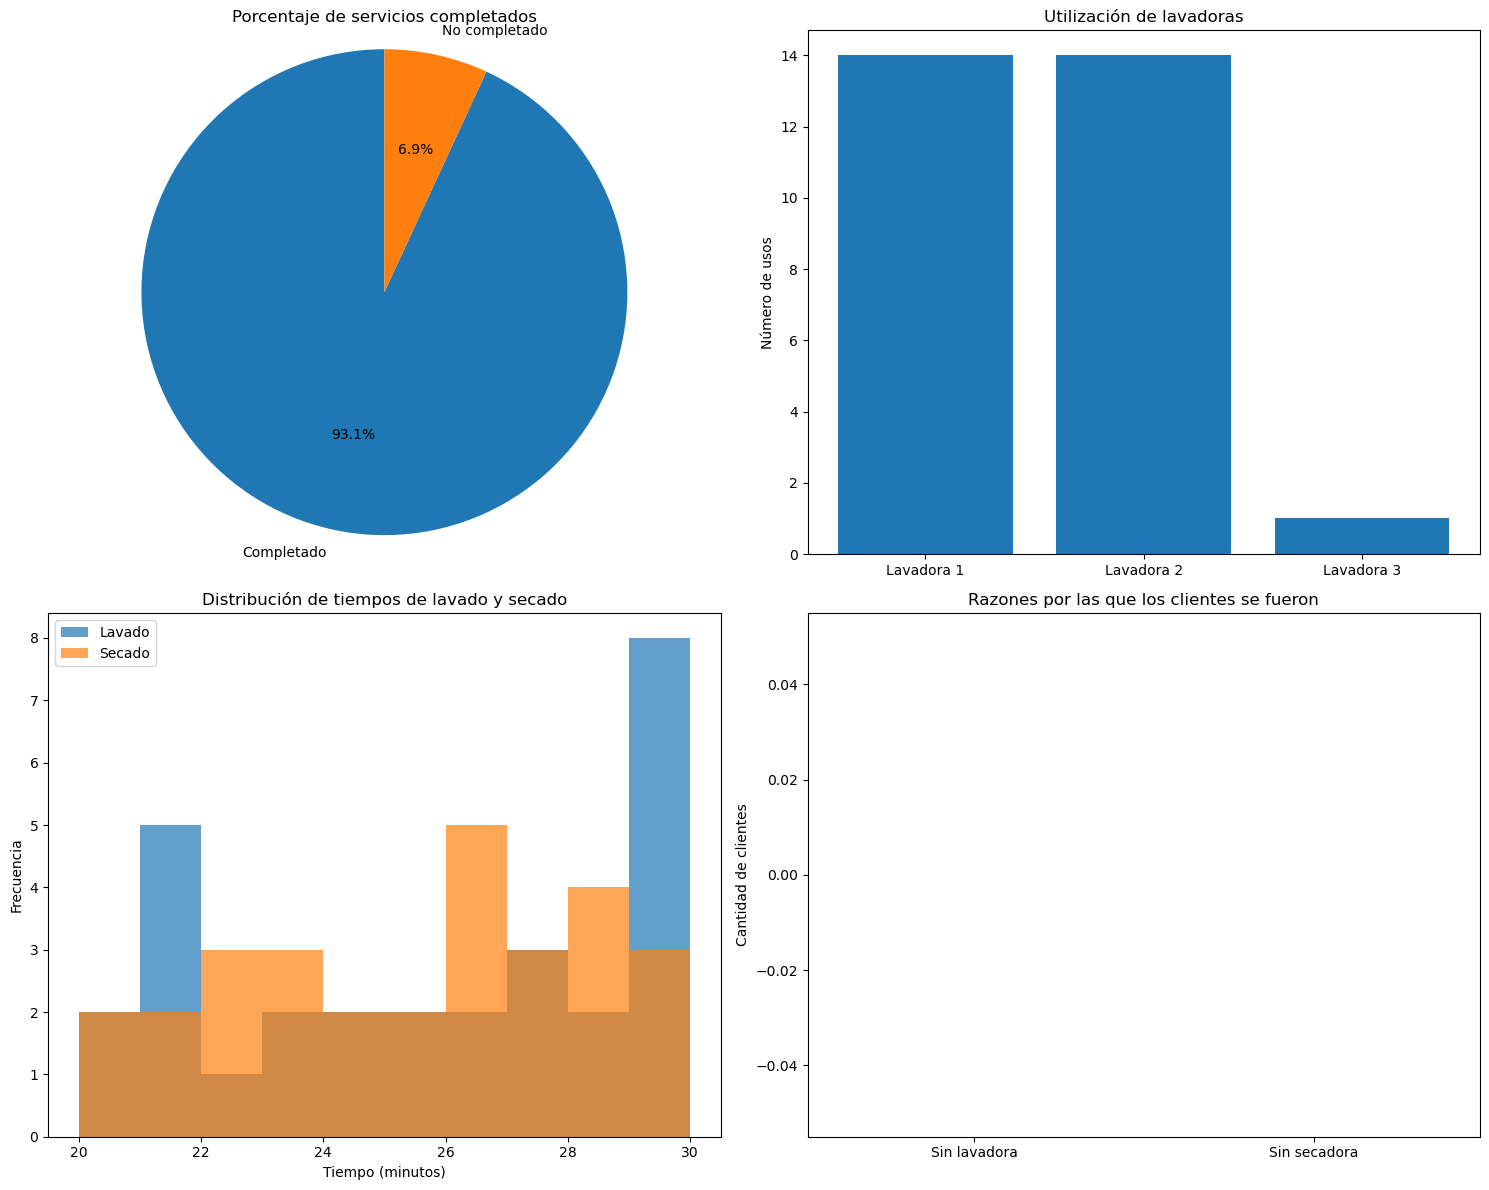

In [12]:
def main():
    # Ejecutar la simulación
    print("Ejecutando simulación de lavandería automática...")
    sim = ejecutar_simulacion(duracion=480)  # 8 horas
    
    # Analizar resultados
    df_eventos, df_clientes = analizar_resultados(sim)
    
    # Responder preguntas
    resultados = responder_preguntas(sim, df_eventos, df_clientes)
    
    # Visualizar resultados
    visualizar_resultados(resultados, df_clientes)
    
    return sim, df_eventos, df_clientes

if __name__ == "__main__":
    main()